In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 핸들링
import numpy as np 
import pandas as pd 

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler ,RobustScaler
from sklearn.model_selection import train_test_split 

#하이퍼 파라미터 튜닝: 보통 랜덤서치로 대략 파악한 다음 그리드 서치로 미세조정
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# 모델
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

# 평가도구 
from sklearn.metrics import accuracy_score

# 교차검증
from sklearn.model_selection import StratifiedKFold


In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [4]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  ----

In [5]:
train4=train.copy()
test4=test.copy()

In [6]:
categorical_cols = ['Stage_fear', 'Drained_after_socializing']
numerical_cols=[
 'Social_event_attendance',
 'Going_outside',
 'Friends_circle_size',
 'Post_frequency']

In [7]:
# 중앙값,평균값 계산
median_value = train4['Time_spent_Alone'].median()
mean_values = train4[numerical_cols].mean()
# 중앙값으로 결측치 채기기
train4['Time_spent_Alone'] = train4['Time_spent_Alone'].fillna(median_value)
test4['Time_spent_Alone'] = test4['Time_spent_Alone'].fillna(median_value)
#평균값으로 결측치 채우기
train4[numerical_cols] = train4[numerical_cols].fillna(mean_values)
test4[numerical_cols] = test4[numerical_cols].fillna(mean_values)

In [8]:
train4.isnull().sum()

id                              0
Time_spent_Alone                0
Stage_fear                   1893
Social_event_attendance         0
Going_outside                   0
Drained_after_socializing    1149
Friends_circle_size             0
Post_frequency                  0
Personality                     0
dtype: int64

In [9]:
train4['total'] = (
    -train4['Time_spent_Alone'] +
     train4['Social_event_attendance'] +
     train4['Going_outside'] +
     train4['Friends_circle_size'] +
     train4['Post_frequency']
)

test4['total'] = (
    -test4['Time_spent_Alone'] +
     test4['Social_event_attendance'] +
     test4['Going_outside'] +
     test4['Friends_circle_size'] +
     test4['Post_frequency']
)

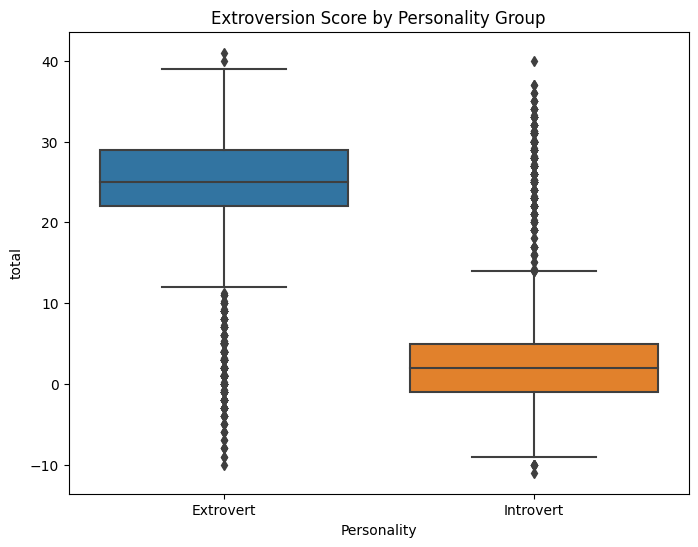

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.boxplot(data=train4, x='Personality', y='total')
plt.title('Extroversion Score by Personality Group')
plt.show()

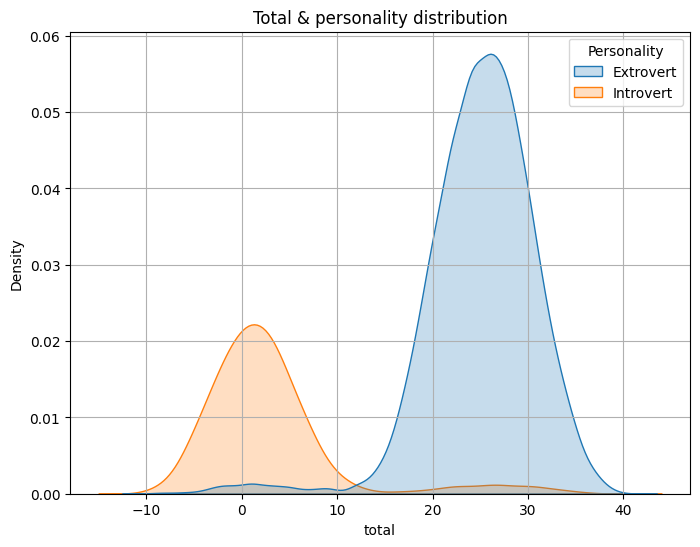

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.kdeplot(data=train4, x='total', hue='Personality', fill=True)
plt.title('Total & personality distribution')
plt.grid(True)
plt.show()

In [12]:
train4['total'].head()

0    30.000000
1    27.000000
2    -2.000000
3    23.000000
4    24.982097
Name: total, dtype: float64

In [13]:
def missing_dist_by_group(df, group_col, target_col):
    
    groups = df[group_col].unique()
    
    for g in groups:
        print(f"\n=== {group_col} = {g} ===")
        subset = df[df[group_col] == g]
        
        missing_count = subset[target_col].isna().sum()
        missing_ratio = subset[target_col].isna().mean()
        
        print(f"결측치 개수: {missing_count}")
        
        
        # 시각화 준비: 결측치는 NaN이니까 "Missing"으로 대체
        plot_data = subset[target_col].fillna('Missing')
        
        plt.figure(figsize=(8,4))
        sns.countplot(data=subset, x=plot_data, order=plot_data.value_counts().index)
        plt.title(f"When {group_col} is {g} '{target_col}'s distribution")
        plt.xlabel(target_col)
        plt.ylabel("빈도수")
        plt.show()




=== Personality = Extrovert ===
결측치 개수: 1149


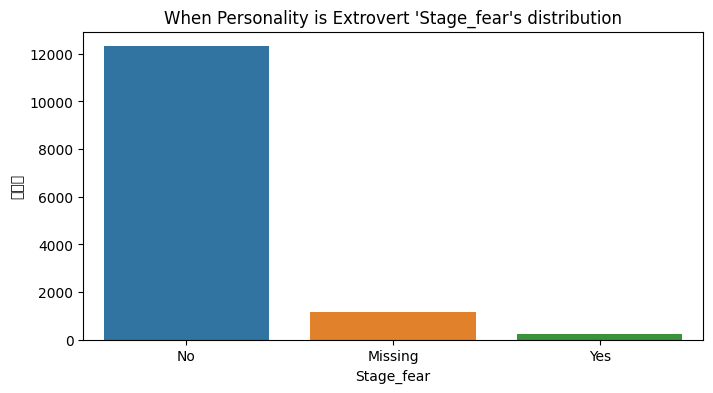


=== Personality = Introvert ===
결측치 개수: 744


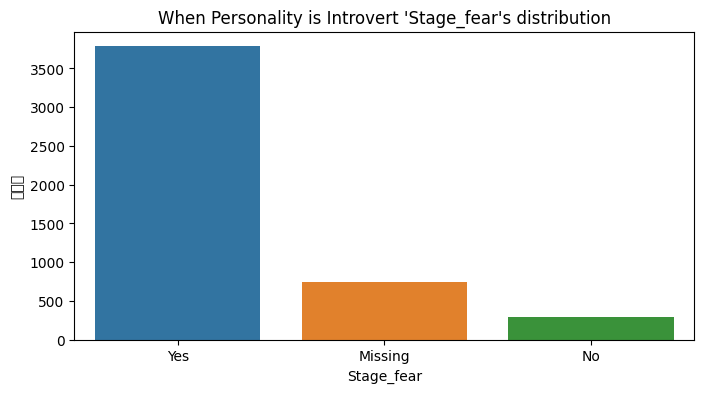

In [14]:
missing_dist_by_group(train4, 'Personality', 'Stage_fear')


=== Personality = Extrovert ===
결측치 개수: 462


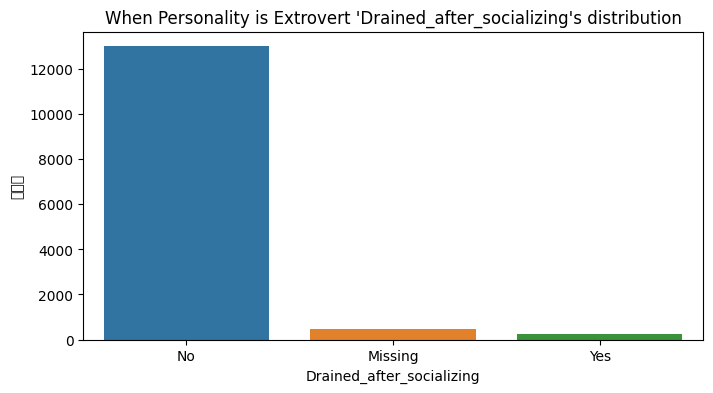


=== Personality = Introvert ===
결측치 개수: 687


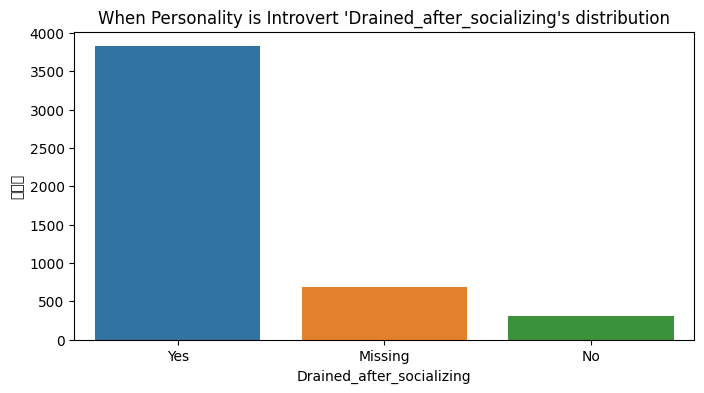

In [15]:
missing_dist_by_group(train4, 'Personality', 'Drained_after_socializing')

In [16]:
train4.loc[train4['Stage_fear'].isnull() & (train4['total'] <= 12), 'Stage_fear'] = 'yes'
train4.loc[train4['Stage_fear'].isnull() & (train4['total'] > 12), 'Stage_fear'] = 'no'
train4.loc[train4['Drained_after_socializing'].isnull() & (train4['total'] <= 12), 'Drained_after_socializing'] = 'yes'
train4.loc[train4['Drained_after_socializing'].isnull() & (train4['total'] > 12), 'Drained_after_socializing'] = 'no'


In [17]:
test4.loc[test4['Stage_fear'].isnull() & (test4['total'] <= 12), 'Stage_fear'] = 'yes'
test4.loc[test4['Stage_fear'].isnull() & (test4['total'] > 12), 'Stage_fear'] = 'no'
test4.loc[test4['Drained_after_socializing'].isnull() & (test4['total'] <= 12), 'Drained_after_socializing'] = 'yes'
test4.loc[test4['Drained_after_socializing'].isnull() & (test4['total'] > 12), 'Drained_after_socializing'] = 'no'


In [18]:
train4.isnull().sum()

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
total                        0
dtype: int64

In [19]:
test4.isnull().sum()

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
total                        0
dtype: int64

In [20]:
le = LabelEncoder()
train4['Stage_fear'] = le.fit_transform(train4['Stage_fear'])
train4['Drained_after_socializing'] = le.fit_transform(train4['Drained_after_socializing'])
test4['Stage_fear'] = le.fit_transform(test4['Stage_fear'])
test4['Drained_after_socializing'] = le.fit_transform(test4['Drained_after_socializing'])

In [21]:
train4['Personality'] = le.fit_transform(train4['Personality'])

In [22]:
train4.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,total
0,0,0.0,0,6.0,4.0,0,15.0,5.000000,0,30.000000
1,1,1.0,0,7.0,3.0,0,10.0,8.000000,0,27.000000
2,2,6.0,1,1.0,0.0,3,3.0,0.000000,1,-2.000000
3,3,3.0,0,7.0,3.0,0,11.0,5.000000,0,23.000000
4,4,1.0,0,4.0,4.0,0,13.0,4.982097,0,24.982097


In [23]:
X = train4.drop(columns=['id','Personality','total'])
y = train4['Personality']

In [24]:
x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=123)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=123)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 랜덤 포레스트 모델 학습
rf = RandomForestClassifier(random_state=123)
rf.fit(X=x_train, y=y_train)

# 예측
y_pred = rf.predict(x_test)

# 정확도 계산
train_score = rf.score(x_train, y_train)
val_score = rf.score(x_val, y_val)

differ = round((train_score - val_score), 3)

if not differ <= 0.05:
    print(differ, '=> 과적합')
else:
    print(differ, '=> 과적합 아님')

print('accuracy =', round(accuracy_score(y_test, y_pred), 3))


0.029 => 과적합 아님
accuracy = 0.967


In [30]:
X_test = test4.drop(columns=['id','total'])
preds = rf.predict(X_test)
preds_labels = ['Extrovert' if x == 1 else 'Introvert' for x in preds]

In [31]:
# 제출 파일 생성
submission3 = pd.DataFrame({'id': test4['id'], 'Personality': preds_labels})
submission3.to_csv('/kaggle/working/submission3.csv', index=False)